# Classifying Urban sounds using Deep Learning

## 4 Model Refinement 

### Load Preprocessed data 

In [1]:
# retrieve the preprocessed data from previous notebook

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r yy 
%store -r le

#### Model refinement

In our inital attempt, we were able to achieve a Classification Accuracy score of: 

* Training data Accuracy:  92.3% 
* Testing data Accuracy:  87% 

We will now see if we can improve upon that score using a Convolutional Neural Network (CNN). 

#### Feature Extraction refinement 

In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files (depending on the samples duration). 

However, CNNs require a fixed size for all inputs. To overcome this we will zero pad the output vectors to make them all the same size. 

In [2]:
import numpy as np
max_pad_len = 862

def extract_features(file_name):
   
    try:
#         print("hello")
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast',duration=20) 
#         print("hello1")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#         print("hello2")
        pad_width = max_pad_len - mfccs.shape[1]
#         print("hello3", pad_width)
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
#         print("hello4")
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [3]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 


metadata = pd.read_csv('./dataset_minor2.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    if row["corona_test"]=="negative":
        file_name = os.path.join(os.path.abspath('clinical/converted_seg/cneg/'),str(row["cough_filename"]))
    else:
        file_name = os.path.join(os.path.abspath('clinical/converted_seg/cpos/'),str(row["cough_filename"]))
    
    class_label = row["corona_test"]
    data = extract_features(file_name)
#     print("file done")
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  121  files


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.4, random_state = 42)

### Convolutional Neural Network (CNN) model architecture 


We will modify our model to be a Convolutional Neural Network (CNN) again using Keras and a Tensorflow backend. 

Again we will use a `sequential` model, starting with a simple model architecture, consisting of four `Conv2D` convolution layers, with our final output layer being a `dense` layer. 

The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution. 


The `filter` parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 64 to 128, while the `kernel_size` parameter specifies the size of the kernel window which in this case is 2 resulting in a 2x2 filter matrix. 

The first layer will receive the input shape of (40, 174, 1) where 40 is the number of MFCC's 174 is the number of frames taking padding into account and the 1 signifying that the audio is mono. 

The activation function we will be using for our convolutional layers is `ReLU` which is the same as our previous model. We will use a smaller `Dropout` value of 20% on our convolutional layers. 

Each convolutional layer has an associated pooling layer of `MaxPooling2D` type with the final convolutional layer having a `GlobalAveragePooling2D` type. The pooling layer is do reduce the dimensionality of the model (by reducing the parameters and subsquent computation requirements) which serves to shorten the training time and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding into our `dense` output layer.  

Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is `softmax`. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [5]:
# import numpy as np
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
# from keras.optimizers import Adam
# from keras.utils import np_utils
# from sklearn import metrics 

# num_rows = 40
# num_columns = 1174
# num_channels = 1

# x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
# x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# num_labels = yy.shape[1]
# filter_size = 2

# # Construct model 
# model = Sequential()
# model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.1))

# # model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
# # model.add(MaxPooling2D(pool_size=2))
# # model.add(Dropout(0.1))
# model.add(GlobalAveragePooling2D())

# model.add(Dense(num_labels, activation='softmax')) 

In [6]:
# import numpy as np
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
# from keras.optimizers import Adam
# from keras.utils import np_utils
# from sklearn import metrics 

# num_rows = 40
# num_columns = 862
# num_channels = 1

# x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
# x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# num_labels = yy.shape[1]
# filter_size = 2

# # Construct model 
# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
# model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu')) 
# model.add(Dropout(0.25))
# model.add(Dense(num_labels, activation='softmax')) 

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 862
num_channels = 1

num_labels = yy.shape[1]
filter_size = 2

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [9]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [10]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 150
num_batch_size = 64

#num_epochs = 110
#num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/150
2/2 [==============================] - 13s 5s/step - loss: 0.8986 - accuracy: 0.4861 - val_loss: 0.7601 - val_accuracy: 0.6531

Epoch 00001: val_loss improved from inf to 0.76011, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 2/150
2/2 [==============================] - 4s 1s/step - loss: 1.1318 - accuracy: 0.5833 - val_loss: 0.6032 - val_accuracy: 0.6531

Epoch 00002: val_loss improved from 0.76011 to 0.60320, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 3/150
2/2 [==============================] - 4s 1s/step - loss: 0.7970 - accuracy: 0.5417 - val_loss: 0.6266 - val_accuracy: 0.7755

Epoch 00003: val_loss did not improve from 0.60320
Epoch 4/150
2/2 [==============================] - 3s 897ms/step - loss: 0.8511 - accuracy: 0.4444 - val_loss: 0.6149 - val_accuracy: 0.7347

Epoch 00004: val_loss did not improve from 0.60320
Epoch 5/150
2/2 [==============================] - 3s 1s/step - loss: 0.7532 - accuracy: 0.5000 - val_loss: 0.6003 -

### Test the model 

Here we will review the accuracy of the model on both the training and test data sets. 

In [11]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.7083333134651184
Testing Accuracy:  0.7346938848495483


The Training and Testing accuracy scores are both high and an increase on our initial model. Training accuracy has increased by ~6% and Testing accuracy has increased by ~4%. 

There is a marginal increase in the difference between the Training and Test scores (~6% compared to ~5% previously) though the difference remains low so the model has not suffered from overfitting. 

In [12]:
##Graph

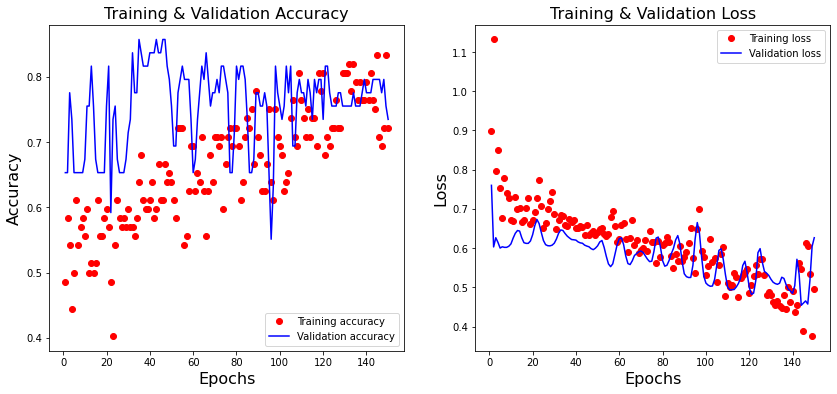

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'ro', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'ro', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

### Predictions  

Here we will modify our previous method for testing the models predictions on a specified audio .wav file. 

In [33]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

### Validation 

#### Test with sample data 

As before we will verify the predictions using a subsection of the sample audio files we explored in the first notebook. We expect the bulk of these to be classified correctly. 

In [34]:
# Class: Neg

filename = './clinical/converted/neg/neg-0421-088-cough-f-66.wav' 
print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.00002283428875671233981847763062
positive 		 :  0.99997711181640625000000000000000


In [35]:
# Class: positive

filename = './clinical/converted/pos/pos-0421-094-cough-m-51.wav'
print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.00000000000000000020957908118859
positive 		 :  1.00000000000000000000000000000000


In [36]:
filename = '../Evaluation audio/Tanya(20-4-2021).wav'

print_prediction(filename)  

The predicted class is: positive 

negative 		 :  0.00115233159158378839492797851562
positive 		 :  0.99884760379791259765625000000000


In [37]:
filename = '../Evaluation audio/DJ.wav'

print_prediction(filename)  

The predicted class is: positive 

negative 		 :  0.03301893919706344604492187500000
positive 		 :  0.96698105335235595703125000000000


In [38]:
filename = '../Evaluation audio/DJ2.wav'

print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.00095842912560328841209411621094
positive 		 :  0.99904149770736694335937500000000


In [39]:
filename = '../Evaluation audio/DJ3.wav'

print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.01584820263087749481201171875000
positive 		 :  0.98415184020996093750000000000000


In [40]:
filename = '../Evaluation audio/Vardhika.wav'

print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.36995902657508850097656250000000
positive 		 :  0.63004100322723388671875000000000


#### Observations 

We can see that the model performs well. 

Interestingly, car horn was again incorrectly classifed but this time as drilling - though the per class confidence shows it was a close decision between car horn with 26% confidence and drilling at 34% confidence.  

### Other audio

Again we will further validate our model using a sample of various copyright free sounds that we not part of either our test or training data. 

In [41]:
filename = '../Evaluation audio/Ghaziabad.wav'
print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.00000128649332964414497837424278
positive 		 :  0.99999868869781494140625000000000


In [42]:
filename = '../Evaluation audio/coughtest2.wav'

print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.00215076794847846031188964843750
positive 		 :  0.99784922599792480468750000000000


In [43]:
filename = '../Evaluation audio/pos-0421-084-cough-m-50-5.wav'

print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.09776136279106140136718750000000
positive 		 :  0.90223866701126098632812500000000


In [44]:
filename = '../Evaluation audio/Ghaziabad3.wav'

print_prediction(filename) 

The predicted class is: positive 

negative 		 :  0.00000000000000010214162523169734
positive 		 :  1.00000000000000000000000000000000


#### Observations 

The performance of our final model is very good and has generalised well, seeming to predict well when tested against new audio data. 

In [45]:
predicted_vector = model.predict_classes(x_test)
le = LabelEncoder()
yy_pred = to_categorical(le.fit_transform(predicted_vector)) 
# print(yy_pred)

Normalized confusion matrix
[[0.62 0.38]
 [0.06 0.94]]


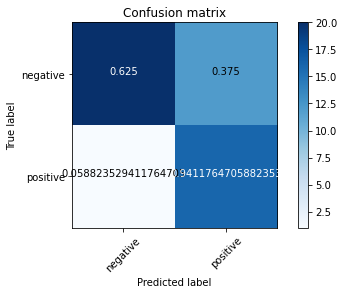

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    np.set_printoptions(precision=2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix=confusion_matrix(y_test.argmax(axis=1),yy_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, ['negative','positive'],
                      'Confusion matrix, without normalization')
plt.show()

In [47]:
print(classification_report(yy_pred.argmax(axis=1),y_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.95      0.75        21
           1       0.94      0.57      0.71        28

    accuracy                           0.73        49
   macro avg       0.78      0.76      0.73        49
weighted avg       0.81      0.73      0.73        49

